# Simulating ultrasound data with zea

This notebook demonstrates how to simulate ultrasound RF data using the `zea` toolbox. We'll define a probe, a scan, and a simple phantom, then use the simulator to generate synthetic RF data. Finally, we'll visualize the results and show how to process the simulated data with a `zea` pipeline.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_simulation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_simulation_example.ipynb)

In [ ]:
%%capture
%pip install zea
%pip install jax[cuda12]

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import zea
from zea import init_device
from zea.simulator import simulate_rf
from zea.probes import Probe
from zea.scan import Scan
from zea.beamform.delays import compute_t0_delays_planewave
from zea.visualize import set_mpl_style

zea: Using backend 'jax'


In [3]:
init_device(verbose=False)
set_mpl_style()

## Making the phantom

Let's define a helper function to plot RF data and a function to generate a simple point scatterer phantom.

In [4]:
def plot_rf(rf_data, title="RF Data", cmap="gray"):
    """Plot the first transmit and first channel of the RF data."""
    plt.figure(figsize=(8, 4))
    plt.imshow(rf_data[0, 0, :, :, 0].T, aspect="auto", cmap=cmap,
               extent=[0, rf_data.shape[2], 0, rf_data.shape[3]])
    plt.xlabel("Sample (axial)")
    plt.ylabel("Element (lateral)")
    plt.title(title)
    plt.colorbar(label="Amplitude")
    plt.tight_layout()

def make_fish_phantom():
    """Returns a scatterer phantom for ultrasound simulation tests.

    Returns:
        ndarray: The scatterer positions of shape (n_scat, 3).
    """
    # The size is the height of the fish
    size = 11e-3
    z_offset = 2.0 * size

    # See https://en.wikipedia.org/wiki/Fish_curve
    def fish_curve(t, size=1):
        x = size * (np.cos(t) - np.sin(t) ** 2 / np.sqrt(2))
        y = size * np.cos(t) * np.sin(t)
        return x, y

    scat_x, scat_z = fish_curve(np.linspace(0, 2 * np.pi, 100), size=size)

    scat_x = np.concatenate(
        [
            scat_x,
            np.array([size * 0.7]),
            np.array([size * 1.1]),
            np.array([size * 1.4]),
            np.array([size * 1.2]),
        ]
    )
    scat_y = np.zeros_like(scat_x)
    scat_z = np.concatenate(
        [
            scat_z,
            np.array([-size * 0.1]),
            np.array([-size * 0.25]),
            np.array([-size * 0.6]),
            np.array([-size * 1.0]),
        ]
    )

    scat_z += z_offset
    return np.stack([scat_x, scat_y, scat_z], axis=1)

## Define `zea.Probe` and `zea.Scan`

We'll use a linear probe and a simple planewave scan for this simulation. Let's start with the probe definition.

In [5]:
# Define a linear probe
n_el = 64
aperture = 20e-3
probe_geometry = np.stack([
    np.linspace(-aperture/2, aperture/2, n_el),
    np.zeros(n_el),
    np.zeros(n_el)
], axis=1)

probe = Probe(
    probe_geometry=probe_geometry,
    center_frequency=5e6,
    sampling_frequency=20e6,
)

Now we'll define the necessary parameters for the scan object.

In [6]:
# Define a planewave scan
n_tx = 3
angles = np.linspace(-5, 5, n_tx) * np.pi / 180
sound_speed = 1540.0

# Set grid and image size
xlims = (-20e-3, 20e-3)
zlims = (10e-3, 35e-3)
width, height = xlims[1] - xlims[0], zlims[1] - zlims[0]
wavelength = sound_speed / probe.center_frequency
Nx = int(width / (0.5 * wavelength)) + 1
Nz = int(height / (0.5 * wavelength)) + 1

t0_delays = compute_t0_delays_planewave(
    probe_geometry=probe_geometry,
    polar_angles=angles,
    sound_speed=sound_speed,
)
tx_apodizations = np.ones((n_tx, n_el)) * np.hanning(n_el)[None]

Now we can initialize the scan object with the defined parameters.

In [7]:
scan = Scan(
    n_tx=n_tx,
    n_el=n_el,
    center_frequency=probe.center_frequency,
    sampling_frequency=probe.sampling_frequency,
    probe_geometry=probe_geometry,
    t0_delays=t0_delays,
    tx_apodizations=tx_apodizations,
    element_width=np.linalg.norm(probe_geometry[1] - probe_geometry[0]),
    focus_distances=np.ones(n_tx) * np.inf,
    polar_angles=angles,
    initial_times=np.ones(n_tx) * 1e-6,
    n_ax=1024,
    xlims=xlims,
    zlims=zlims,
    Nx=Nx,
    Nz=Nz,
    lens_sound_speed=1000,
    lens_thickness=1e-3,
    n_ch=1,
    selected_transmits="all",
    sound_speed=sound_speed,
    apply_lens_correction=False,
    attenuation_coef=0.0,
)

## Simulate RF Data

Let's simulate some RF data using the `simulate_rf` function and the scatterer phantom we created earlier.

In [8]:
# Create the phantom scatterer positions and magnitudes
positions = make_fish_phantom()
magnitudes = np.ones(len(positions), dtype=np.float32)

rf_data = simulate_rf(
    scatterer_positions=positions,
    scatterer_magnitudes=magnitudes,
    probe_geometry=probe.probe_geometry,
    apply_lens_correction=scan.apply_lens_correction,
    lens_thickness=scan.lens_thickness,
    lens_sound_speed=scan.lens_sound_speed,
    sound_speed=scan.sound_speed,
    n_ax=scan.n_ax,
    center_frequency=probe.center_frequency,
    sampling_frequency=probe.sampling_frequency,
    t0_delays=scan.t0_delays,
    initial_times=scan.initial_times,
    element_width=scan.element_width,
    attenuation_coef=scan.attenuation_coef,
    tx_apodizations=scan.tx_apodizations,
)
print("Simulated RF data shape:", rf_data.shape)

2025-06-12 11:12:48.162843: I external/xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


Simulated RF data shape: (1, 3, 1024, 64, 1)


## Visualize RF Data

Let's plot the simulated RF data for the first transmit.

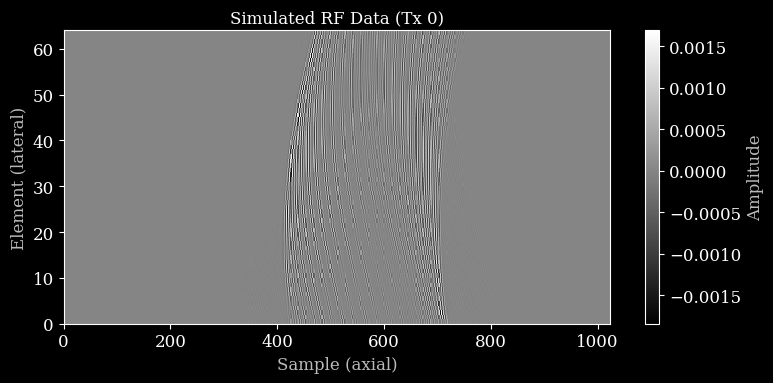

In [9]:
plot_rf(rf_data, title="Simulated RF Data (Tx 0)")

## Process simulated data with `zea.Pipeline`

We can process the simulated RF data using a Zea pipeline to obtain a B-mode image.

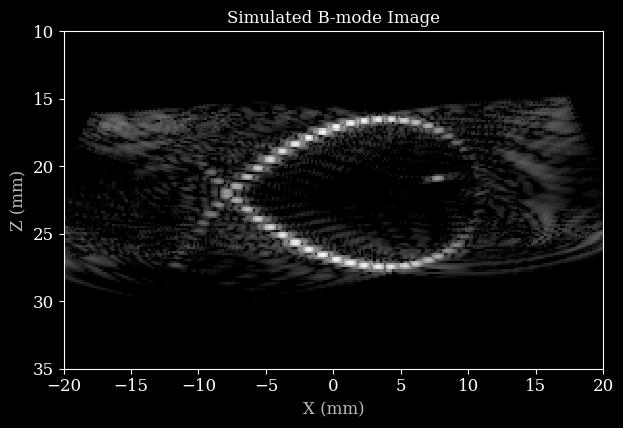

In [10]:
pipeline = zea.Pipeline.from_default(pfield=False, with_batch_dim=False, baseband=False)
parameters = pipeline.prepare_parameters(probe, scan)
inputs = {pipeline.key: rf_data[0]}  # Use first batch

outputs = pipeline(**inputs, **parameters, dynamic_range=(-50, 0))
image = outputs[pipeline.output_key]

image = zea.display.to_8bit(image, dynamic_range=(-50, 0))

plt.figure()
plt.imshow(
    image, cmap="gray",
    extent=[
        scan.xlims[0]*1e3, scan.xlims[1]*1e3,
        scan.zlims[1]*1e3, scan.zlims[0]*1e3,
    ],
)
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
plt.title("Simulated B-mode Image")
plt.tight_layout()

That's it! You have now simulated ultrasound RF data and reconstructed a B-mode image using `zea`.